In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.algos.logsigrnn.vae import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import FunctionTransformer
import pickle
from sklearn.pipeline import Pipeline

from src.algos.logsigrnn.utils import *
from src.algos.logsigrnn.sigutils import *
from src.algos.logsigrnn.dyadic_sigutils import *
from src.algos.logsigrnn.vae import *
from src.algos.logsigrnn.logsigrnn import *

In [4]:
X = np.load('_input/train_new_data.npy')

labels = pickle.load(open(r'_input/train_label.pkl', 'rb'))[1]
one_hot_encoder = OneHotEncoder(sparse=False)
y = one_hot_encoder.fit_transform(np.array(labels).reshape(-1, 1))

In [31]:
vae.decoder(vae.encoder(tf.constant([[0.9, 0.9]])))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1.        , 0.69739056]], dtype=float32)>

In [36]:
VAETransformer??

Init signature: VAETransformer(n_input, n_intermediate, n_latent, epsilon_std) -> None
Docstring:      <no docstring>
Source:        
class VAETransformer:

    def __init__(self, n_input, n_intermediate, n_latent, epsilon_std) -> None:

        self.n_input = n_input
        self.n_intermediate = n_intermediate
        self.n_latent = n_latent
        self.epsilon_std = epsilon_std

        self.encoder, self.decoder, self.vae = build_vae_model(n_input, n_intermediate, n_latent, epsilon_std)

    def fit(self, X, y, **fit_params):

        train_index, test_index = train_test_split(np.arange(len(X)), test_size=0.15)

        X_train = X[train_index].reshape(-1, self.n_input)
        X_test = X[test_index].reshape(-1, self.n_input)

        self.vae.fit(X_train, X_train, validation_data=(X_test, X_test), **fit_params)

        return self

    def transform(self, X):

        # %% prepare features and labels X, y for spatial signatures vae model

        X_sigs = X.reshape((X.shape[0] 

In [ ]:
vae = VAETransformer(2, 2, 10, 0.001)

xs = np.random.uniform(0, 1, (1000, 2)).astype(np.float32)
vae.fit(xs, xs, epochs=1000)

In [ ]:
vae = VAETransformer(102, 64, 4, 0.1)
scaler = MinMaxScaler()
X_ = scaler.fit_transform(X.transpose(0, 2, 4, 3, 1).reshape(-1, 102))
vae.fit(X_, X_, epochs=3, batch_size=1024)

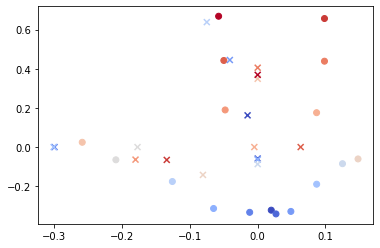

In [33]:
x_true = X[130, :, 30, :, :].reshape(1, 102)
x_pred = scaler.inverse_transform(vae.decoder(vae.encoder(scaler.transform(x_true))))

fig, ax = plt.subplots()
ax.scatter(*x_true.reshape(-1, 3, 17, 2)[:1, [0, 1], :, 0], c=10*np.arange(17), cmap='coolwarm')
ax.scatter(*x_pred.reshape(-1, 3, 17, 2)[:1, [0, 1], :, 0], c=10*np.arange(17), cmap='coolwarm', marker='x')

In [47]:
reshape1 = FunctionTransformer(lambda X: X.transpose((0, 2, 4, 3, 1)).reshape(len(train_index) * X.shape[2], -1))
scaler = MinMaxScaler()
reshape2 = FunctionTransformer(lambda X: X.reshape(len(train_index), 305, -1))
vae = VAETransformer(102, 72, 40, 0.1)

# %% build model


input_shape = (305, 40)

clf = build_logsigrnn_model(input_shape=input_shape,
                            projection_mode=0,
                            lstm_mode=0,
                            n_segments=(32,),
                            drop_rate_2=0.8,
                            signature_degree=2,
                            filter_size_1=5,
                            n_projection_neurons=40,
                            n_joints=17,
                            n_classes=155,
                            learning_rate=0.001,
                            n_hidden_neurons=64)


early_stopping_monitor = EarlyStopping(monitor='loss', min_delta=0, patience=20, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=50, verbose=1, factor=0.8, min_lr=0.000001)

callbacks = [early_stopping_monitor, reduce_lr]

pipeline = Pipeline([
    ('reshape1', reshape1),
    ('scaler', scaler),
    ('reshape2', reshape2),
    ('vae', vae),
    ('clf', clf),
])

pipeline.fit(X[train_index], y[train_index],
             clf__callbacks=callbacks,
             clf__epochs=300,
             clf__batch_size=256,
             clf__validation_split=0.15,
             vae__epochs=3,
             vae__batch_size=1024)

NameError: name 'train_index' is not defined

In [3]:
original_dim = 784
intermediate_dim = 256
latent_dim = 2
epsilon_std = 1.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist


original_dim = 784
intermediate_dim = 256
latent_dim = 16
batch_size = 100
epochs = 50
epsilon_std = 1.0


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = K.random_normal(stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=x, outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

encoder = Model(x, z_mu)

600/600 [==============================] - 7s 12ms/step - loss: 115.0325 - val_loss: 112.6277


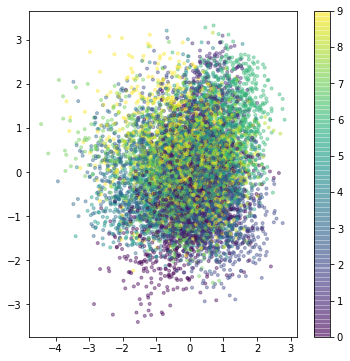

ValueError: in user code:

    /usr/local/lib/python3.9/site-packages/keras/engine/training.py:1544 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/site-packages/keras/engine/training.py:1527 run_step  *
        outputs = model.predict_step(data)
    /usr/local/lib/python3.9/site-packages/keras/engine/training.py:1500 predict_step  *
        return self(x, training=False)
    /usr/local/lib/python3.9/site-packages/keras/engine/base_layer.py:989 __call__  *
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.9/site-packages/keras/engine/input_spec.py:248 assert_input_compatibility  *
        raise ValueError(

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: expected axis -1 of input shape to have value 16 but received input with shape (None, 2)


In [42]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=1,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()


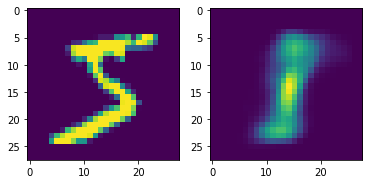

In [26]:
fig, ax = plt.subplots(ncols=2)

a = x_train[0].reshape(28, 28)
ax[0].imshow(a)

b = 255 * decoder(encoder(a.reshape(1, -1)/255)).numpy().reshape(28, 28)
ax[1].imshow(b)

In [ ]:
vae_transformer = VAETransformer(784, 256, 2, 1.)
vae_transformer.fit(x_train, epochs=10, shuffle=True, batch_size=100, validation_data=(x_test, x_test))

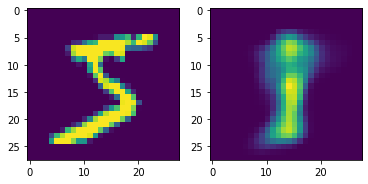

In [28]:
fig, ax = plt.subplots(ncols=2)

a = x_train[0].reshape(28, 28)
ax[0].imshow(a)

b = 255 * vae_transformer.decoder(vae_transformer.encoder(a.reshape(1, -1)/255)).numpy().reshape(28, 28)
ax[1].imshow(b)